In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import activeloop
import matplotlib.pyplot as plt
import numpy as np

import datajoint as dj
dj.config["enable_python_native_blobs"] = True

# Generating datasets of rendered Stimuli

### Part 1: Without datajoint

#### 1. Call dataset_function to generate configurations for individual images

In [3]:
from activeloop.datasets import demo_dataset

In [4]:
image_configs = demo_dataset(seed=1, 
                             n_images=5, 
                             image_size=(100,100),
                             rotations=(-20,20), 
                             objects=["circle", "square"],)

In [5]:
image_configs

[{'image_size': (100, 100), 'rotation': 17, 'object': 'circle'},
 {'image_size': (100, 100), 'rotation': -8, 'object': 'circle'},
 {'image_size': (100, 100), 'rotation': -12, 'object': 'square'},
 {'image_size': (100, 100), 'rotation': -11, 'object': 'circle'},
 {'image_size': (100, 100), 'rotation': -9, 'object': 'square'}]

#### 2. Pass the configs into the generator_function

In [6]:
from activeloop.generators import render_image

In [7]:
images, latents = [], []
for config in image_configs:
    img, latent, meta_data = render_image(**config) 
    images.append(img)
    latents.append(latent)

In [8]:
images = np.stack(images) # size (5, 100, 100) -> (n_images, height, width)
latents = np.stack(latents) # size (5, 10, 100, 100) -> (n_images, n_latents, height_width)

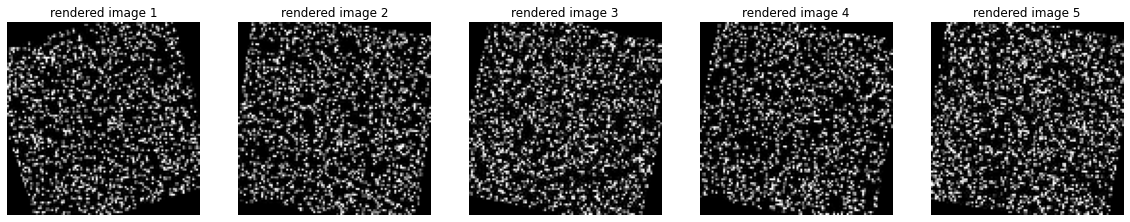

In [9]:
fig, axs = plt.subplots(1,5, figsize=(20,4))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(images[i], cmap="gray")
    ax.axis("off")
    ax.set_title(f"rendered image {i+1}")

In [10]:
latents.shape # each image as 10 latent dimensions. Each latent is the size of the image. For example segmentation maps, depth maps, and so on.

(5, 10, 100, 100)

In [11]:
print(meta_data)

{'number of objects': 1, 'camera angle': 45}


# With Datajoint

#### Overview

There are 3 tables already implemented:
- 1. The `GenerateDataset` table, which stores the dataset_function, generator_function, and the dataset_config
- 2. The `ImageConfig` table is a part table of (1), and stores the configs for all individual images
- 3. The `RenderedImages` table, a computed table, which renderes the actual images from (2) and stores the images, latents, and meta info.

In [13]:
from activeloop.schema.main import GenerateDataset
from activeloop.schema.rendered_images import RenderedImages

In [14]:
GenerateDataset()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,dataset_config dataset configuration object,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion


In [15]:
GenerateDataset.ImageConfig()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,image_id image id,image_config


In [16]:
RenderedImages()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,image_id image id,"image actual image, np.ndarray (c, h, w) with c = channels","latents image latents, np.ndarray (n, h, w) with n = number of latents",meta_data other form of meta data,rendering_ts UTZ timestamp at time of insertion


## 1. Insert a Dataset function

In [17]:
# specify the functions and the configs, from the example above
dataset_fn = "activeloop.datasets.demo_dataset"
dataset_config = dict(seed=1, 
                      n_images=5, 
                      image_size=(100,100),
                      rotations=(-20,20), 
                      objects=["circle", "square"]
                     )
generator_fn = "activeloop.generators.render_image"

In [18]:
# inserting a new entry should only be done with the add_entry method, which automatically generates a hash based on the config
GenerateDataset().add_entry(dataset_fn=dataset_fn,
                           dataset_config=dataset_config,
                           generator_fn=generator_fn,
                           dataset_comment="example entry",)

{'dataset_fn': 'activeloop.datasets.demo_dataset',
 'dataset_hash': 'b1b746917ce155d77d79a39fc43f4120',
 'generator_fn': 'activeloop.generators.render_image',
 'dataset_config': {'seed': 1,
  'n_images': 5,
  'image_size': (100, 100),
  'rotations': (-20, 20),
  'objects': ['circle', 'square']},
 'dataset_comment': 'example entry'}

In [19]:
GenerateDataset() # looks good

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,dataset_config dataset configuration object,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,=BLOB=,example entry,2023-01-10 18:51:45


#### Sanity Checks

In [20]:
# adding the entry works because both functions (generator and dataset) are actually defined

# the dataset_fn and generator_fn attributes in the tables are just strings. But they can be turned into actual callable functions with the use of some helpers

dataset_fn, generator_fn = GenerateDataset().fetch1("dataset_fn", "generator_fn")

In [21]:
# the output is just a string
print(dataset_fn)
print(generator_fn)

activeloop.datasets.demo_dataset
activeloop.generators.render_image


In [22]:
# importing helper functions

In [23]:
from activeloop.schema.main import resolve_data, resolve_generator

resolve_data(dataset_fn) # now it is a function

<function activeloop.datasets.demo_rendered_dataset.demo_dataset(seed: int = 0, n_images: int = 100, image_size: Tuple[int, int] = (100, 100), rotations: Tuple[int, int] = (-45, 45), objects: List[str] = None) -> List[Dict]>

In [24]:
resolve_generator(generator_fn) # same here

<function activeloop.generators.demo_generator.render_image(image_size: Tuple[int, int], rotation: int, object: str) -> Tuple[numpy.ndarray, numpy.ndarray, Dict]>

In [25]:
## what would happen if we add a table entry with a function that does not exist?

dataset_fn = "activeloop.datasets.demo_dataset"
dataset_config = dict(seed=1, 
                      n_images=10000, 
                      image_size=(100,100),
                      rotations=(-20,20), 
                      objects=["circle", "square"]
                     )

#generator that does not exist
generator_fn = "activeloop.generators.very_fancy_renderer"

# inserting a new entry with the unkown generator_fn
GenerateDataset().add_entry(dataset_fn=dataset_fn,
                           dataset_config=dataset_config,
                           generator_fn=generator_fn,
                           dataset_comment="unkown entry")

AttributeError: module 'activeloop.generators' has no attribute 'very_fancy_renderer'

it will look in `activeloop.generators` if there is such a function, and it will error out if there is none

## 2. Fill the ImageConfig table

In [26]:
# now that the Dataset table has an entry, filling the ImageConfig table is easy

GenerateDataset().ImageConfig()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,image_id image id,image_config


In [27]:
GenerateDataset()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,dataset_config dataset configuration object,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,=BLOB=,example entry,2023-01-10 18:51:45


In [28]:
# define a key to restrict the table to one entry
key = dict(dataset_hash="b1b746917ce155d77d79a39fc43f4120")
GenerateDataset() & key

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,dataset_config dataset configuration object,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,=BLOB=,example entry,2023-01-10 18:51:45


In [29]:
# to fill the entries, the get_image_configs method is called

GenerateDataset().get_image_configs(key)

[{'image_size': [100, 100], 'rotation': 17, 'object': 'circle'},
 {'image_size': [100, 100], 'rotation': -8, 'object': 'circle'},
 {'image_size': [100, 100], 'rotation': -12, 'object': 'square'},
 {'image_size': [100, 100], 'rotation': -11, 'object': 'circle'},
 {'image_size': [100, 100], 'rotation': -9, 'object': 'square'}]

In [30]:
# fill up entries in the part table

GenerateDataset().ImageConfig().fill(key)

... filling individual image tables ...


In [32]:
GenerateDataset().ImageConfig()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,image_id image id,image_config
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,0,=BLOB=
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,1,=BLOB=
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,2,=BLOB=
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,3,=BLOB=
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,4,=BLOB=


In [33]:
# here are out image configs
GenerateDataset().ImageConfig().fetch("image_config")

array([{'image_size': [100, 100], 'rotation': 17, 'object': 'circle'},
       {'image_size': [100, 100], 'rotation': -8, 'object': 'circle'},
       {'image_size': [100, 100], 'rotation': -12, 'object': 'square'},
       {'image_size': [100, 100], 'rotation': -11, 'object': 'circle'},
       {'image_size': [100, 100], 'rotation': -9, 'object': 'square'}],
      dtype=object)

# 3. Render the Images

In [34]:
# now let's render the images
key = dict(dataset_hash="b1b746917ce155d77d79a39fc43f4120")

In [35]:
RenderedImages()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,image_id image id,"image actual image, np.ndarray (c, h, w) with c = channels","latents image latents, np.ndarray (n, h, w) with n = number of latents",meta_data other form of meta data,rendering_ts UTZ timestamp at time of insertion


In [36]:
# this table is a computed table, so it fills itself and can be filled in parallel on many machines

In [37]:
RenderedImages().populate(key,
                         display_progress=True,
                         reserve_jobs=True)

100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


In [38]:
RenderedImages()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,generator_fn name of the generator function,image_id image id,"image actual image, np.ndarray (c, h, w) with c = channels","latents image latents, np.ndarray (n, h, w) with n = number of latents",meta_data other form of meta data,rendering_ts UTZ timestamp at time of insertion
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,0,=BLOB=,=BLOB=,=BLOB=,2023-01-10 18:52:58
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,1,=BLOB=,=BLOB=,=BLOB=,2023-01-10 18:52:58
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,2,=BLOB=,=BLOB=,=BLOB=,2023-01-10 18:52:58
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,3,=BLOB=,=BLOB=,=BLOB=,2023-01-10 18:52:58
activeloop.datasets.demo_dataset,b1b746917ce155d77d79a39fc43f4120,activeloop.generators.render_image,4,=BLOB=,=BLOB=,=BLOB=,2023-01-10 18:52:59


In [39]:
image = (RenderedImages() & dict(image_id=0)).fetch1("image")

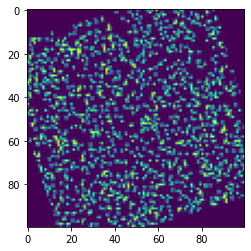

In [40]:
plt.imshow(image)